In [1]:
#import the library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
champs = pd.read_csv(r'D:\Documents\ML\LOL\champs.csv')
matches = pd.read_csv(r'D:\Documents\ML\LOL\matches.csv')
participants = pd.read_csv(r'D:\Documents\ML\LOL\participants.csv')
stats1 = pd.read_csv(r'D:\Documents\ML\LOL\stats1.csv')
stats2 = pd.read_csv(r'D:\Documents\ML\LOL\stats2.csv')
stats = stats1.append(stats2)
#filtering
col_list = ['id','win','kills','deaths','assists','totdmgtochamp','magicdmgtochamp','physdmgtochamp','totheal','dmgselfmit','totcctimedealt',
           'totdmgtaken','goldearned','turretkills','inhibkills','totminionskilled','champlvl','wardsplaced','firstblood']
stats = stats[col_list]

C:\Users\ASUS\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (52) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df = pd.merge(participants,stats, how ='right', on = ['id'])
df = pd.merge(df,champs, how ='left', left_on ='championid',right_on='id')
df = pd.merge(df,matches, how ='left' ,left_on ='matchid', right_on = 'id')

In [4]:
def final_position(row):
    if row['role'] in ('DUO_SUPPORT', 'DUO_CARRY'):
        return row['role'][4:]
    else:
        return row['position']
df['adjposition'] = df.apply(final_position, axis = 1) 
df['team'] = df['player'].apply(lambda x: '1' if x <= 5 else '2')
df['team_role'] = df['team'] + '-' + df['adjposition']
remove_index = []
for i in ('1-MID', '1-TOP', '1-SUPPORT', '1-CARRY', '1-JUNGLE', '2-MID', '2-TOP', '2-SUPPORT', '2-CARRY', '2-JUNGLE'):
    df_remove = df[df['team_role'] == i].groupby('matchid').agg({'team_role':'count'})
    remove_index.extend(df_remove[df_remove['team_role']!=1].index.values)   
remove_index.extend(df[df['adjposition'] == 'BOT']['matchid'].unique())
remove_index = list(set(remove_index))
df = df[-df['matchid'].isin(remove_index)]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1486359 entries, 0 to 1834516
Data columns (total 39 columns):
id_x                1486359 non-null int64
matchid             1486359 non-null int64
player              1486359 non-null int64
championid          1486359 non-null int64
ss1                 1486359 non-null int64
ss2                 1486359 non-null int64
role                1486359 non-null object
position            1486359 non-null object
win                 1486359 non-null int64
kills               1486359 non-null int64
deaths              1486359 non-null int64
assists             1486359 non-null int64
totdmgtochamp       1486359 non-null int64
magicdmgtochamp     1486359 non-null int64
physdmgtochamp      1486359 non-null int64
totheal             1486359 non-null int64
dmgselfmit          1486359 non-null int64
totcctimedealt      1486359 non-null int64
totdmgtaken         1486359 non-null int64
goldearned          1486359 non-null int64
turretkills         14863

# Categorize the features
- Categorical Features:
    team,team_role,adjposition,seasonid,firstblood.
- Continous Feature:
    the dmg, heal, taken dmg, wardsplaced, champ lvl, kDA


# Analyzing the features

# First blood

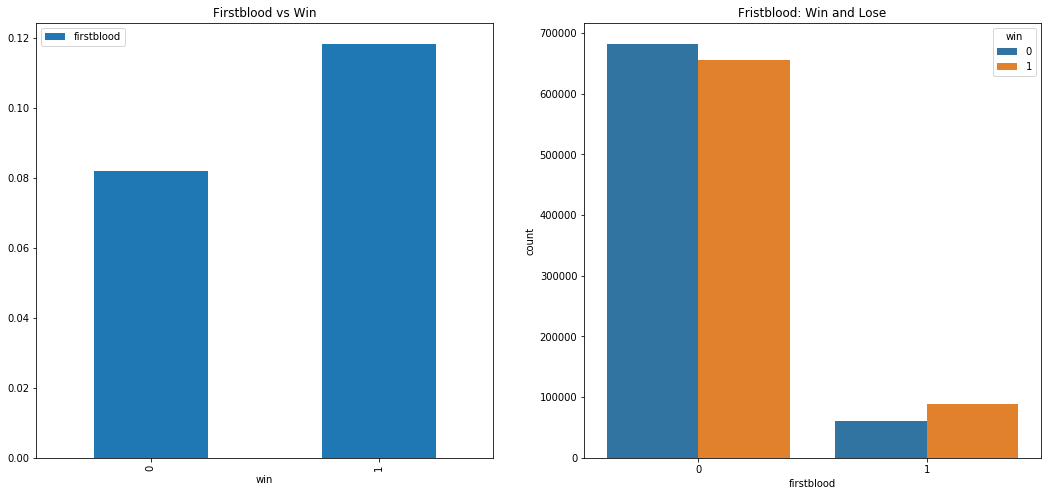

In [6]:
f,ax=plt.subplots(1,2,figsize=(18,8))
df[['win','firstblood']].groupby(['win']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Firstblood vs Win')
sns.countplot('firstblood',hue='win',data=df,ax=ax[1])
ax[1].set_title('First blood: Win and Lost')
plt.show()

# Season, first blood and win rate

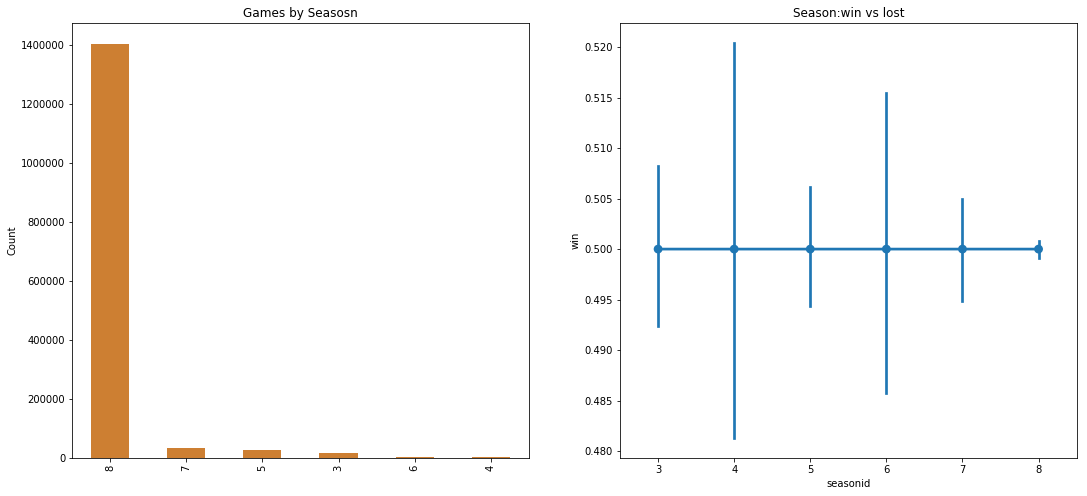

In [16]:
f,ax=plt.subplots(1,2,figsize=(15,8))
df['seasonid'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'],ax=ax[0])
ax[0].set_title('Games by Seasons')
ax[0].set_ylabel('Count')
sns.factorplot('seasonid','win',data=df,ax=ax[1])
ax[1].set_title('Season:win vs lost')
plt.close(2)
plt.show()

# Win and lost rate by teams

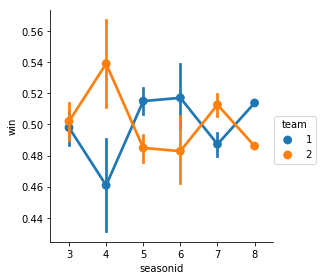

In [18]:
sns.factorplot('seasonid','win',hue='team',data=df)
plt.show()

- The season 8 data is dominant over the others and League has a very rapid updating rate. Thus, we should only focus on the season 8.

In [19]:
df = df[df['seasonid']==8]

In [21]:
df[['team_role','win']].groupby(['team_role']).mean()

,win
team_role,
1-CARRY,0.513871
1-JUNGLE,0.513871
1-MID,0.513871
1-SUPPORT,0.513874
1-TOP,0.513867
2-CARRY,0.486129
2-JUNGLE,0.486125
2-MID,0.486132
2-SUPPORT,0.486129


# Correlation Between the Features

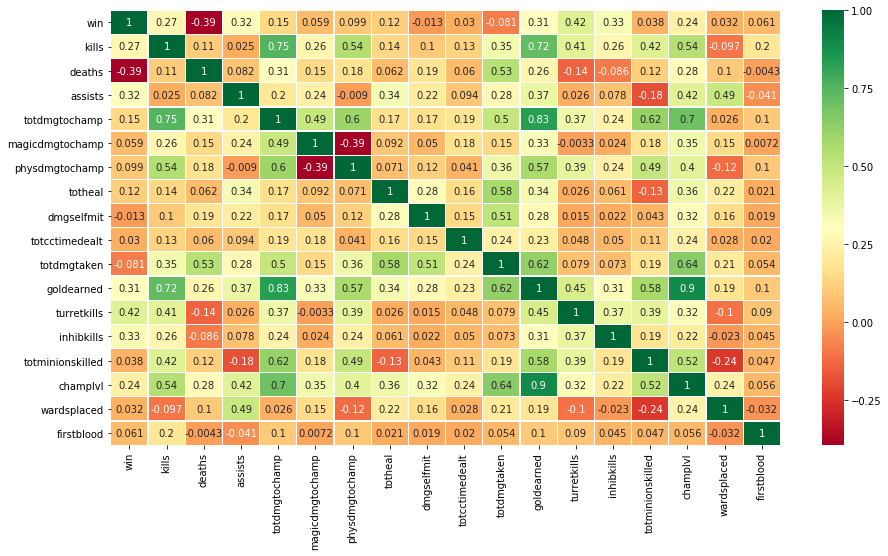

In [24]:
col = ['win','kills','deaths','assists','totdmgtochamp','magicdmgtochamp','physdmgtochamp','totheal','dmgselfmit','totcctimedealt',
           'totdmgtaken','goldearned','turretkills','inhibkills','totminionskilled','champlvl','wardsplaced','firstblood']
df_copy = df.copy()
df_copy = df_copy[col]
# Cor map
sns.heatmap(df_copy.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(15,8)
plt.show()

# Spliting for different roles
- The roles have a huge impact on the features about damage, healing, and taken damage, etc...
- I think we should split the role and visualize its features.

In [27]:
df_TOP = df[df['adjposition']=='TOP']
df_MID = df[df['adjposition']=='MID']
df_JUNGLE = df[df['adjposition']=='JUNGLE']
df_CARRY = df[df['adjposition']=='CARRY']
df_SUPPORT = df[df['adjposition']=='SUPPORT']

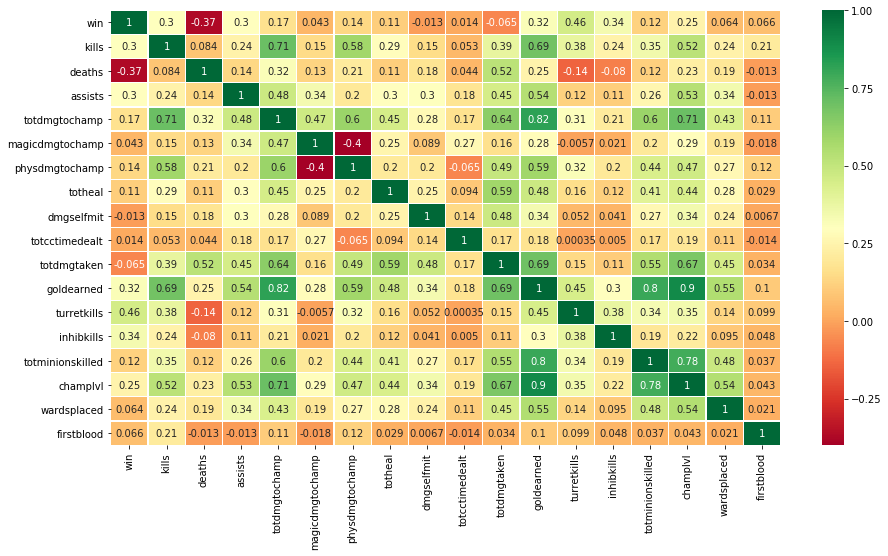

In [28]:
sns.heatmap(df_TOP[col].corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(15,8)
plt.show()

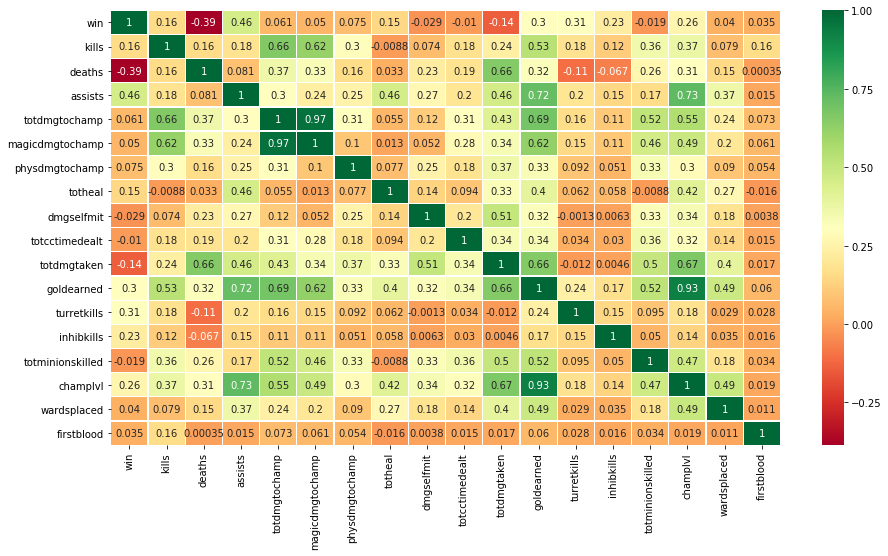

In [29]:
sns.heatmap(df_SUPPORT[col].corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(15,8)
plt.show()

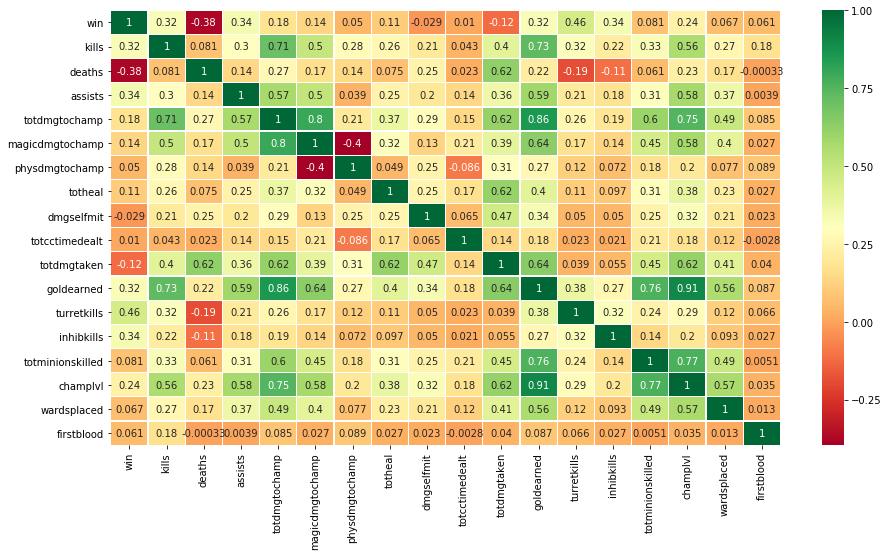

In [30]:
sns.heatmap(df_MID[col].corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(15,8)
plt.show()

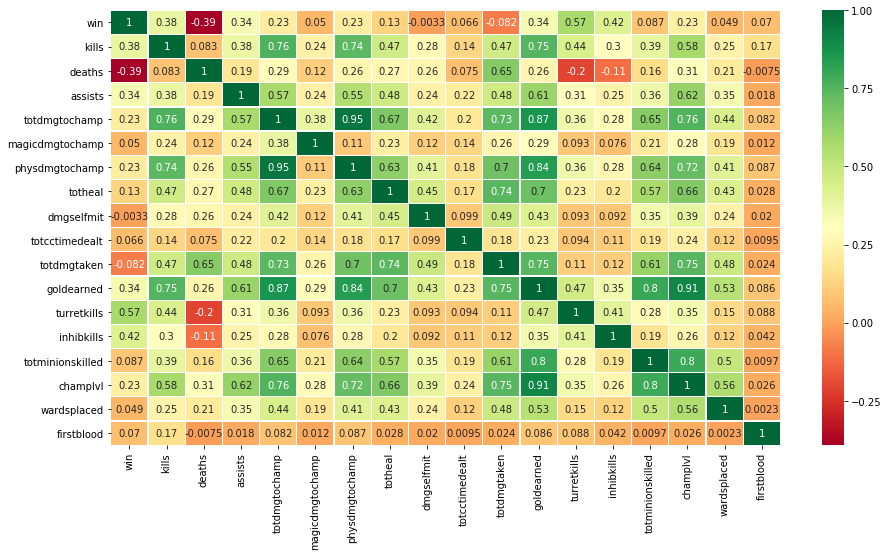

In [31]:
sns.heatmap(df_CARRY[col].corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(15,8)
plt.show()

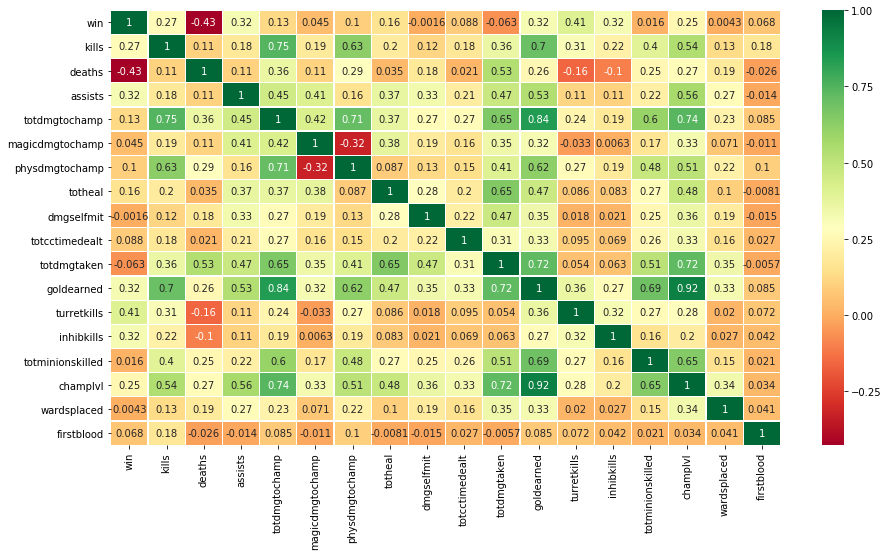

In [32]:
sns.heatmap(df_JUNGLE[col].corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(15,8)
plt.show()